In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from evaluation import forecast_accuracy

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

print(df.isna().sum())
print(df.dtypes)

DOA         0
DBA         0
LAR      5040
ADR      4950
Rooms       0
ROH         0
dtype: int64
DOA       object
DBA      float64
LAR      float64
ADR      float64
Rooms    float64
ROH      float64
dtype: object


In [3]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)

    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in dx.columns }

    # renaming columns
    dx = dx.rename(columns=cols)
    dx = dx.rename(columns={'ROH01':'ROH'})

    # reversing the sequance of attributes
    return dx.sort_index(axis=1 ,ascending=False)

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], label='LSTM')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

In [4]:
data = preprocess(df)
train,test = train_test_split(data)
train.head(10)

DBA,ROH90,ROH60,ROH30,ROH21,ROH14,ROH07,ROH06,ROH05,ROH04,ROH03,ROH02,ROH
2018-01-01,0.019608,0.160000,0.440000,0.590909,0.744186,0.744186,0.744186,0.767442,0.767442,0.790698,0.813953,0.860465
2018-01-02,0.217391,0.340909,0.386364,0.522727,0.581395,0.744186,0.767442,0.767442,0.767442,0.767442,0.813953,0.906977
2018-01-03,0.260870,0.340909,0.386364,0.545455,0.674419,0.720930,0.744186,0.744186,0.720930,0.860465,0.906977,0.906977
2018-01-04,0.152174,0.227273,0.318182,0.431818,0.418605,0.488372,0.465116,0.488372,0.604651,0.674419,0.697674,0.860465
2018-01-05,0.108696,0.181818,0.295455,0.318182,0.325581,0.372093,0.395349,0.395349,0.465116,0.488372,0.511628,0.813953
2018-01-06,0.043478,0.431818,0.428571,0.448980,0.437500,0.511628,0.534884,0.581395,0.604651,0.627907,0.651163,0.674419
2018-01-07,0.021739,0.022727,0.045455,0.090909,0.116279,0.139535,0.162791,0.236842,0.263158,0.236842,0.210526,0.277778
2018-01-08,0.043478,0.068182,0.159091,0.232558,0.372093,0.365854,0.390244,0.414634,0.439024,0.414634,0.538462,0.812500
2018-01-09,0.043478,0.068182,0.181818,0.255814,0.441860,0.465116,0.488372,0.488372,0.465116,0.585366,0.692308,0.941176
2018-01-10,0.021739,0.045455,0.136364,0.325581,0.395349,0.511628,0.511628,0.511628,0.609756,0.625000,0.700000,0.974359


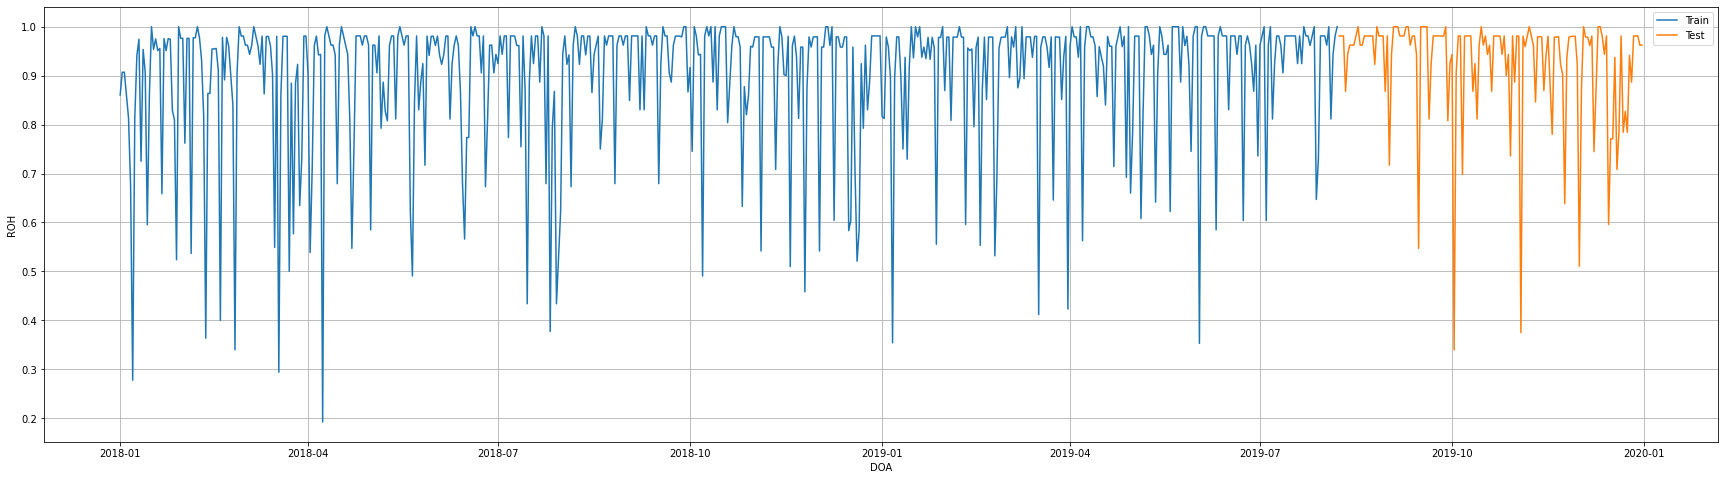

In [5]:
plot_train_test(train,test)

## Model Selection

In [6]:
y = train.pop('ROH')
X = train

In [7]:
param = {'kernel' :['rbf'],'C' : [1,5,10], 'epsilon':[0.01,0.1],'gamma' : ('auto','scale')},

modelsvr = SVR()
grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=5,scoring='neg_mean_squared_error')
grids.fit(X,y)
grids.best_params_
grids.best_estimator_

SVR(C=10, epsilon=0.01, gamma='auto')

In [8]:
test_predict_cols = [attr for attr in test.columns if attr!='ROH']
test['PRED']  = grids.predict(test[test_predict_cols])

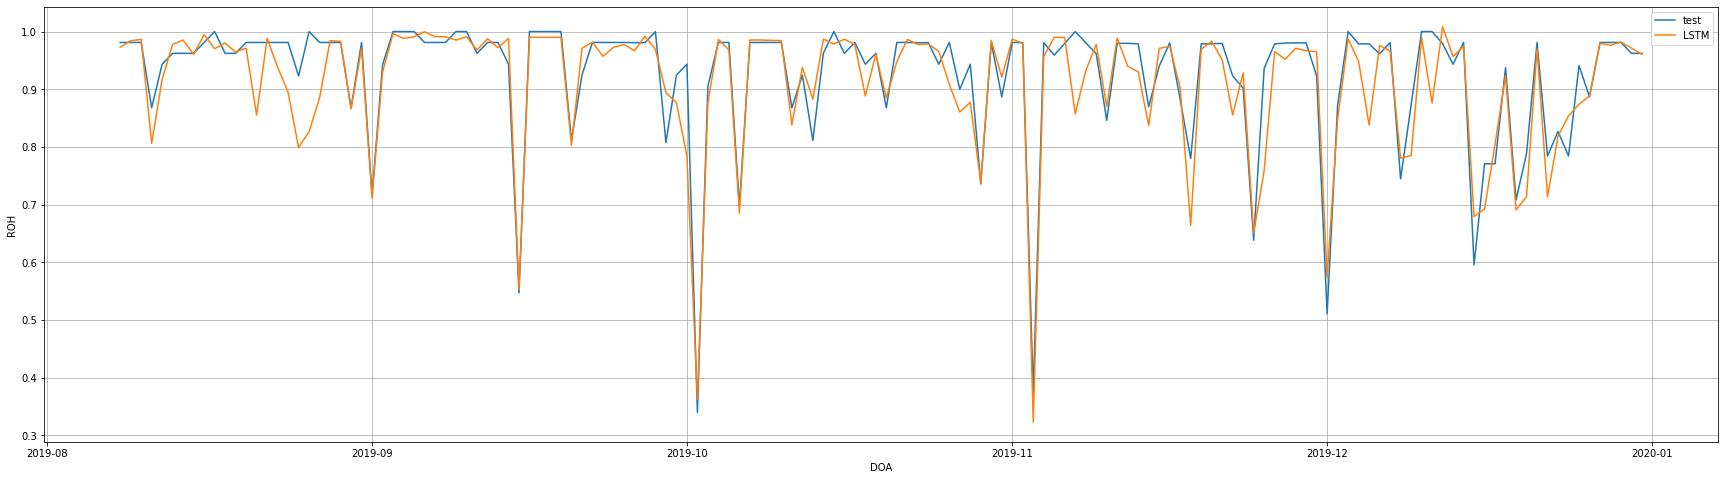

In [9]:
plot_result(test)

In [10]:
forecast_accuracy(test['PRED'],test['ROH'])

0.0455	&	0.0143	&	0.0304	&	3.4631	&	0.0477	&	0.0023	&	0.8235


## With attributes

In [12]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)
    dx = dx[~dx['LAR'].isna()]
    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    occ = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    occ = occ.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in occ.columns }
    # renaming columns
    occ = occ.rename(columns=cols)
    occ = occ.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

    # DBA as attributes 
    lar = dx.pivot(index='DOA', columns='DBA', values='LAR')
    # Removing sub index from Dataframe
    lar = lar.rename_axis(None, axis = 0)
    cols = {col:'LAR'+str(int(col+1)).zfill(2) for col in lar.columns }
    # renaming columns
    lar = lar.rename(columns=cols)
    lar = lar.rename(columns={'LAR01':'LAR'})

    lar['DOW'] = lar.index.dayofweek
    lar['Mon'] = lar.index.month
    lar['Day'] = lar.index.day
    # standardizing prices
    scaler = StandardScaler()
    lar[lar.columns] = scaler.fit_transform(lar[lar.columns])

    dx = pd.concat([lar, occ],axis=1)
    # reversing the sequance of attributes
    return dx

## Combined results

In [13]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
clean_hotels = [  48,   80,   86,  148,  151,  199,  269,  284,  317,  322,  577,1041, 1100, 1479, 1968, 4290]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    print([0]+cuttoffs[i:])
    for hotelId in clean_hotels:
        df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
        df = preprocess(df,[0]+cuttoffs[i:])
        train, test = train_test_split(df)
        cols = [col for col in df.columns if col != 'ROH']
        # creating model 
        y = train.pop('ROH')
        X = train
        # grid search best params
        param = {'kernel' :['rbf'],'C' : [1,5,10], 'epsilon':[0.01,0.1],'gamma' : ('auto','scale')},
        modelsvr = SVR()
        grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=10,scoring='neg_mean_squared_error')
        grids.fit(X,y)
        # grids.best_params_
        # print(grids.best_estimator_)
        # predict with best parameter
        test['PRED'] = grids.predict(test[cols])
        # plot 
        # plot_result(test)    
        # evaluation
        forecast_accuracy(test['PRED'],test['ROH'])

- DBA  0
[0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.055	&	0.0138	&	0.0399	&	4.8513	&	0.0578	&	0.0033	&	0.7545
0.051	&	-0.0292	&	0.0409	&	5.1709	&	0.0545	&	0.003	&	0.7896
0.0555	&	-0.0128	&	0.0374	&	5.5606	&	0.0556	&	0.0031	&	0.935
0.0487	&	-0.0223	&	0.0339	&	4.5894	&	0.0505	&	0.0026	&	0.9318
0.0393	&	-0.0038	&	0.0315	&	3.6981	&	0.0393	&	0.0015	&	0.8758
0.2479	&	-inf	&	0.1113	&	inf	&	0.2599	&	0.0675	&	0.0436
0.0534	&	0.0131	&	0.0375	&	4.5522	&	0.0561	&	0.0032	&	0.756
0.0373	&	0.0033	&	0.0274	&	2.9725	&	0.0375	&	0.0014	&	0.8566
0.053	&	-0.0181	&	0.0391	&	4.7353	&	0.0542	&	0.0029	&	0.6739
0.0388	&	-0.0109	&	0.0298	&	3.555	&	0.0393	&	0.0015	&	0.8203
0.0375	&	-0.0062	&	0.0278	&	3.7502	&	0.0377	&	0.0014	&	0.9689
0.0219	&	-0.0005	&	0.0166	&	1.9772	&	0.0219	&	0.0005	&	0.8627
0.043	&	-0.0081	&	0.0328	&	3.736	&	0.0433	&	0.0019	&	0.7183
0.0329	&	-0.0106	&	0.0253	&	2.9215	&	0.0337	&	0.0011	&	0.9314
0.0516	&	-0.0123	&	0.038	&	4.7847	&	0.0519	&	0.0027	&	0.8907
0.0528	&	0.0068	&	0.0384	&	4.607	&	0.0